In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.feature_extraction.image import extract_patches_2d


device = torch.device('cuda:0')

In [110]:
class Classifier(nn.Module):
    def __init__(self, in_dim=16,out_size=10):
        super(Classifier, self).__init__()
        hidden_dim = 1024
        self.layer1 = nn.Linear(in_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim,out_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self,x):
        x = self.layer1(x).clamp(min=0)
        x = self.softmax(self.layer2(x))
        return x
    
class DeeperClassifier(nn.Module):
    def __init__(self, in_dim=16,out_size=10):
        super(DeeperClassifier, self).__init__()
        hidden_dim = 1024
        self.layer1 = nn.Linear(in_dim,hidden_dim)
        self.layer3 = nn.Linear(hidden_dim,hidden_dim)
        self.layer4 = nn.Linear(hidden_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim,out_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self,x):
        x = self.layer1(x).clamp(min=0)
        x = self.layer3(x).clamp(min=0)
        x = self.layer4(x).clamp(min=0)
        x = self.softmax(self.layer2(x))
        return x

In [172]:
def rotation_matrix(n):
    matrix = np.eye(n)
    for _ in range(5):
        num_matrices = int(n/2)
        thetas = np.random.uniform(0,6.28,num_matrices)
        rows = []
        for i in range(num_matrices):
            first_row = np.zeros((1,n))
            second_row = np.zeros((1,n))
            first_row[0,2*i] = np.cos(thetas[i])
            first_row[0,2*i+1] = -np.sin(thetas[i])
            second_row[0,2*i] = np.sin(thetas[i])
            second_row[0,2*i+1] = np.cos(thetas[i])
            rows.append(np.concatenate([first_row,second_row],axis=0))
        temp_matrix = np.concatenate(rows,axis=0)
        np.random.shuffle(temp_matrix)
        matrix = matrix@temp_matrix
    return matrix

In [173]:
num_samples = 10000
num_dim = 16
data = np.random.normal(0,1,num_samples*num_dim).reshape(num_samples,num_dim)
label = np.random.uniform(0,10,num_samples).astype(np.int64)
sigmas = np.arange(num_dim)+1
A = rotation_matrix(num_dim)
data = (A@(data*sigmas).T).T

class myDataset(torch.utils.data.Dataset):
    def __init__(self,data,label,rand_label):
        self.data = data
        self.label = label
        self.rand_label = rand_label
        
    def __getitem__(self,index):
        return torch.FloatTensor(self.data[index]), self.label[index], self.rand_label[index]
    def __len__(self):
        return self.data.shape[0]
    
batch_size = 32
train_set = myDataset(data,label,np.random.permutation(label))

temp = data.T
mean = temp.mean(axis=1,keepdims=True)
covData = np.cov(temp-mean)

eigenValues, eigenVectors = np.linalg.eig(covData)

idx = eigenValues.argsort()[::-1]   
DataVals = eigenValues[idx]
DataVecs = eigenVectors[:,idx].T

RandomVecs = np.random.normal(size=DataVecs.shape)
RandomVecs = RandomVecs/np.linalg.norm(RandomVecs,axis=1,keepdims=True)

In [7]:
def misaligment(covariance,eigenvecs):
    incovariance = np.linalg.inv(covariance)
    score = 0
    for i in range(eigenvecs.shape[0]):
        score += np.sqrt((eigenvecs[i:i+1,:]@(covariance@eigenvecs[i:i+1,:].T))*(eigenvecs[i:i+1,:]@(incovariance@eigenvecs[i:i+1,:].T)))-1
    return score[0][0]

def mapping(covariance,eigenvecs,eigenvals):
    mappings_1,mappings_2 = [],[]
    for i in range(eigenvecs.shape[0]):
        mappings_1.append(float(eigenvecs[i:i+1,:]@(covariance@eigenvecs[i:i+1,:].T)))
        mappings_2.append(np.log(float(eigenvals[i])))
    return mappings_2,mappings_1


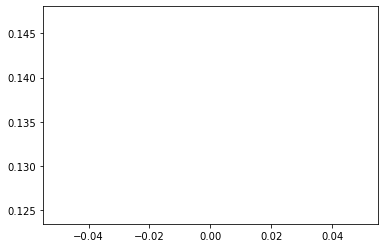

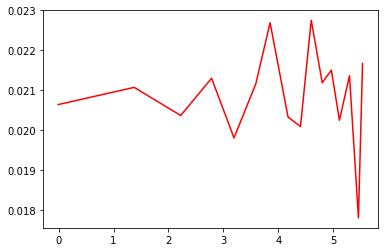

tensor(9046., device='cuda:0')


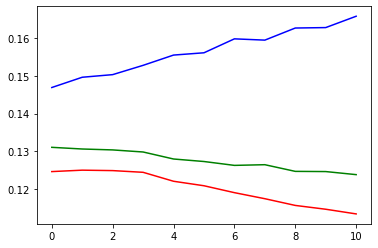

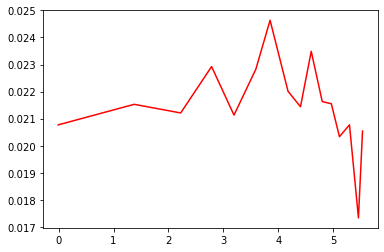

tensor(6980., device='cuda:0')


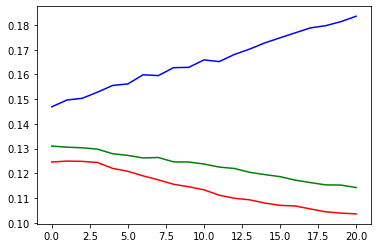

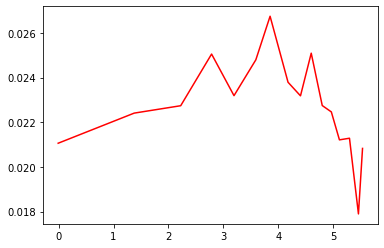

tensor(5138., device='cuda:0')


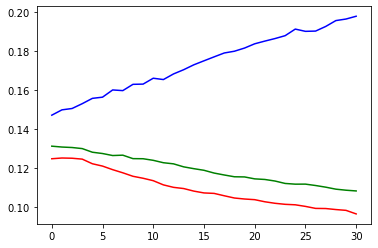

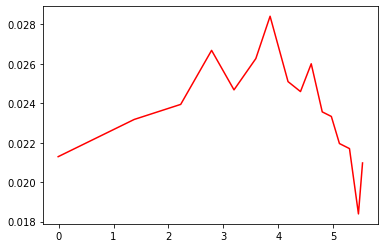

tensor(4352., device='cuda:0')


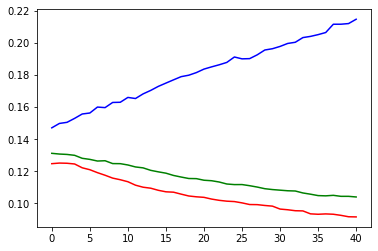

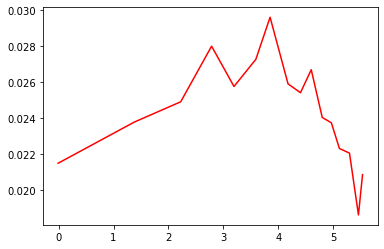

tensor(4002., device='cuda:0')


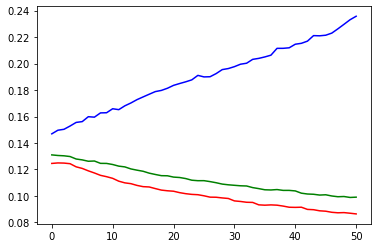

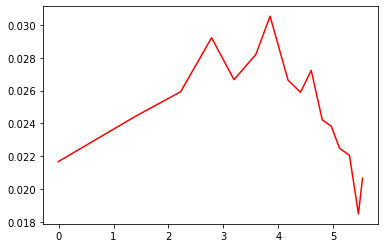

tensor(3791., device='cuda:0')


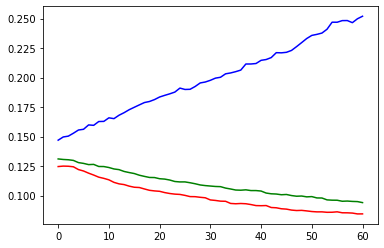

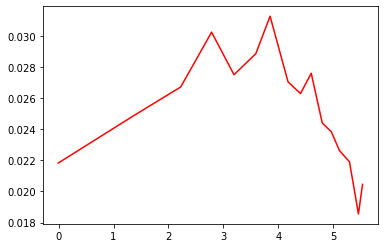

tensor(3611., device='cuda:0')


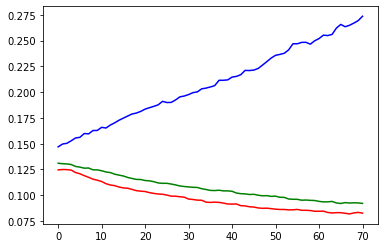

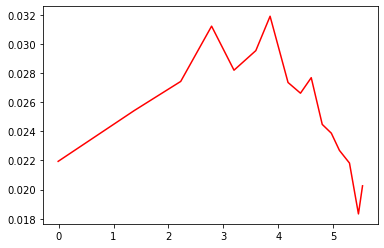

tensor(3439., device='cuda:0')


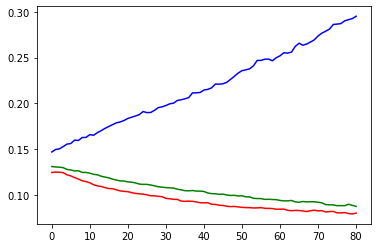

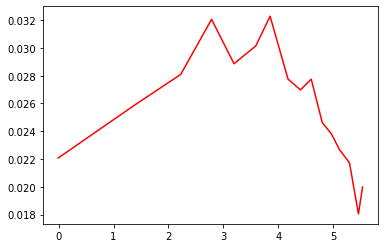

tensor(3317., device='cuda:0')


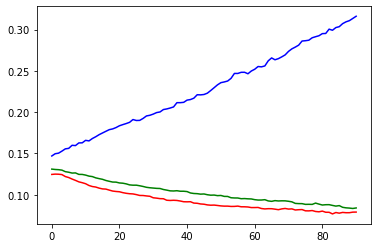

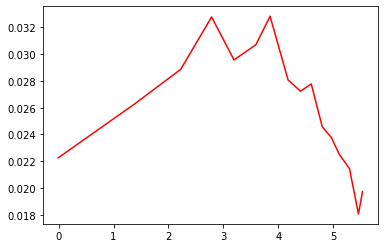

tensor(3202., device='cuda:0')


In [174]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size,drop_last = False,shuffle=True)
classifier = DeeperClassifier
# classifier = Classifier
model_random = classifier().to(device)
model = classifier().to(device)
optimizer = torch.optim.Adam(list(model.parameters())+list(model_random.parameters()),lr=1e-4)
lossfn = torch.nn.CrossEntropyLoss()
alignment_eigen_random,alignment_random_random,alignment_eigen_real= [],[],[]
maxEpoch = 100

for epoch in range(maxEpoch):
    incorrect = 0 
    for i,(x,y,yrand) in enumerate(train_loader):
        y_pred = model(x.to(device))
        yrand_pred = model_random(x.to(device))
        loss = lossfn(y_pred,y.to(device))+lossfn(yrand_pred,yrand.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         incorrect += (torch.argmax(yrand_pred,dim=1)!=yrand.to(device)).float().sum()
        incorrect += (torch.argmax(y_pred,dim=1)!=y.to(device)).float().sum()
        
        if (i%10000 == 0):
            for x in model_random.layer1.parameters():
                covDataFilters = np.cov(x.cpu().detach().numpy().T)
                break
            alignment_eigen_random.append(misaligment(covDataFilters,DataVecs))
            alignment_random_random.append(misaligment(covDataFilters,RandomVecs))
            
            eigen_mapping_random = mapping(covDataFilters,DataVecs,DataVals)
            
            for x in model.layer1.parameters():
                covDataFilters = np.cov(x.cpu().detach().numpy().T)
                break
            alignment_eigen_real.append(misaligment(covDataFilters,DataVecs))
            eigen_mapping_real = mapping(covDataFilters,DataVecs,DataVals)

    if (epoch%10 == 0):
        plt.plot(np.array(alignment_eigen_random),c='r')
        plt.plot(np.array(alignment_random_random),c='b')
        plt.plot(np.array(alignment_eigen_real),c='g')
        plt.show()
        plt.plot(eigen_mapping_random[0],eigen_mapping_random[1],c='r')
        plt.show()
        print (incorrect)


In [175]:
# t_correlated_mapping_random = eigen_mapping_random
# t_correlated_mapping_real = eigen_mapping_real
# t_uncorrelated_mapping_random = eigen_mapping_random
# t_uncorrelated_mapping_real = eigen_mapping_real
# t_mildcorrelated_mapping_random = eigen_mapping_random
# t_mildcorrelated_mapping_real = eigen_mapping_real
t_mildcorrelated2_mapping_random = eigen_mapping_random
t_mildcorrelated2_mapping_real = eigen_mapping_real


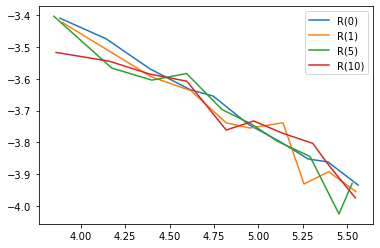

In [186]:
for t,hidden_size in zip([t_uncorrelated_mapping_random,t_mildcorrelated_mapping_random,t_mildcorrelated2_mapping_random,t_correlated_mapping_random],['R(0)','R(1)','R(5)','R(10)']):
#     plt.plot(np.log(t[0]),label="EigenVectors,RandomLabels,%s"%hidden_size)
    plt.plot(t[0][:10],np.log(t[1][:10]),label="%s"%hidden_size)
#     plt.plot(t[0],np.log(t[1]),label="%s"%hidden_size)
#     plt.plot(np.log(t[1]),label="RandomVectors,RandomLabels,%d"%hidden_size)
#     plt.plot(np.log(t[2]),label="EigenVectors,RealLabels,%s"%hidden_size)
#     plt.plot(t[1],c='b')
#     plt.plot(t[2],c='g')
    plt.legend(loc ="upper right")
#     plt.legend(["EigenVectors,RandomLabels,%d"%hidden_size,"RandomVectors,RandomLabels,%d"%hidden_size,"EigenVectors,RealLabels,%d"%hidden_size], loc ="upper left")
#     plt.show()